<a href="https://colab.research.google.com/github/sarashahin/DiabetesRetinopathyDectetion_UNet_augment./blob/main/DiabetesRetinopathyDectetion_UNet_augment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



1.   First of all, data(the image)is loaded and preprocessed
2.   and converted into an array format.
3.   The array values represent the pixel intensities.
4.   Self-implement U-net (done)
5.   Train U-Net
6.   Metrics for segmentation problems






In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import os
import pandas as pd
import tensorflow as tf
import numpy as np
from PIL import Image
from IPython.display import display
import tensorflow.keras.backend as K   
import imageio
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

from tensorflow.keras.layers import Conv2D, Dense, Conv2DTranspose, MaxPooling2D, Concatenate
from tensorflow.keras import Input, Model
import matplotlib.image as mpimg

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras import optimizers as opt
from keras.layers import Lambda





**Input data**

In [ ]:
path = ''
train_image_path = os.path.join(path, './drive/MyDrive/training/image/')
# image_path.strip()
train_image_path
train_mask_path = os.path.join(path, './drive/MyDrive/training/mask/')

test_image_path = os.path.join(path, './drive/MyDrive/test/images/')
test_mask_path = os.path.join(path, './drive/MyDrive/test/mask/')

train_image_list = os.listdir(train_image_path)
train_mask_list = os.listdir(train_mask_path)

test_image_list = os.listdir(test_image_path)
test_mask_list = os.listdir(test_mask_path)

train_image_list = [train_image_path+i for i in train_image_list]
train_mask_list = [train_mask_path+i for i in train_mask_list]

test_image_list = [test_image_path+i for i in test_image_list]
test_mask_list = [test_mask_path+i for i in test_mask_list]

print(test_image_list[10])
print(test_mask_list[1])

In [ ]:
test_image_list = [f for f in test_image_list if not f.endswith('.DS_Store')]


**Check data**

Text(0.5, 1.0, 'Segmentation')

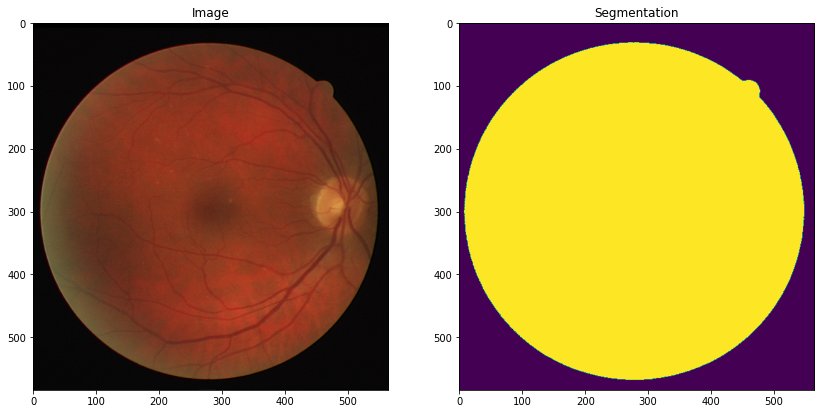

In [ ]:
N = 3
img = imageio.imread(train_image_list[N])
img
mask = imageio.imread(train_mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:,:,])
arr[1].set_title('Segmentation')

In [ ]:
train_image_list_ds = tf.data.Dataset.list_files(train_image_list, shuffle=False)
train_mask_list_ds = tf.data.Dataset.list_files(train_mask_list, shuffle=False)

test_image_list_ds = tf.data.Dataset.list_files(test_image_list, shuffle=False)
test_mask_list_ds = tf.data.Dataset.list_files(test_mask_list, shuffle=False)

print(img.shape)
print(mask.shape)



(584, 565, 3)
(584, 565)


In [ ]:

train_image_filenames = tf.constant(train_image_list)
train_masks_filenames = tf.constant(train_mask_list)
print("image_filenames", train_image_filenames.shape)

test_image_filenames = tf.constant(test_image_list)
test_masks_filenames = tf.constant(test_mask_list)
print("test_image_filenames", test_image_filenames)


**Preprocess data**

This is a code snippet for image processing and augmentation using TensorFlow.

The process_path function takes two paths as input, an image path and a mask path, reads the image and the mask, and converts them to float32 data type. The mask is converted to a single channel image and then the maximum value of all the channels is taken to create a binary mask.

The preprocess function takes the image and the mask and resizes them to (224, 224) using the nearest neighbor method. The image and mask values are then normalized by dividing by 255.

The augment function takes the preprocessed image and mask and applies random transformations to the image. The random transformations include flipping the image horizontally, changing the brightness, contrast, saturation, and hue of the image.

The output of the augment function is a tuple of the augmented image and the original mask.

In [ ]:
# Load the image and mask data
def process_path(image_path, mask_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_png(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  
  mask = tf.io.read_file(mask_path)
  mask = tf.image.decode_png(mask, channels=1)
  # mask = mask[:,:,0] # keep only the first channel
  mask = tf.image.convert_image_dtype(mask, tf.float32)
  mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)

  print("mask1", mask.shape)

  return img, mask

def preprocess(image, mask):
  input_image = tf.image.resize(image, (224, 224), method='nearest')
  input_mask = tf.image.resize(mask, (224, 224), method='nearest')
  print("input_image",input_image.shape)
  print("input_mask",input_mask.shape)

  input_image = input_image / 255.
  input_mask = input_mask / 255.

  return input_image, input_mask

def augment(image, mask):
  image, mask = preprocess(image, mask)
  print("image",image.shape)
  print("mask",mask.shape)

  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, max_delta=0.5)
  image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
  image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
  image = tf.image.random_hue(image, max_delta=0.2)

  print("image.shape",image.shape)

  print("mask.shape",mask.shape)
  return image, mask



In [ ]:

# Load and augment the data
def load_and_augment(image_path, mask_path):
  image, mask = process_path(image_path, mask_path)
  image, mask = augment(image, mask)
  # image_and_mask = tf.stack([image, mask], axis=-1)
  print("mask.shape1",mask.shape, image.shape)
  return image, mask

# Create the dataset
def create_dataset(image_paths, mask_paths, batch_size=32, shuffle_buffer_size=None, repeat=True):
  images = tf.data.Dataset.from_tensor_slices(image_paths)
  masks = tf.data.Dataset.from_tensor_slices(mask_paths)
  dataset = tf.data.Dataset.zip((images, masks))
  dataset = dataset.map(load_and_augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.cache()
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

  if shuffle_buffer_size:
    dataset = dataset.shuffle(shuffle_buffer_size)
  dataset = dataset.batch(batch_size)
  
  if repeat:
    dataset = dataset.repeat(5)
  return dataset

# Create the training and validation datasets
batch_size = 32
train_dataset = create_dataset(train_image_filenames, train_masks_filenames, batch_size=batch_size, shuffle_buffer_size=len(train_image_filenames), repeat=True)
validation_dataset = create_dataset(test_image_filenames, test_masks_filenames, batch_size=batch_size, repeat=False)

print("train_dataset",train_dataset)
print("validation_dataset",validation_dataset )


This is a code snippet for creating a U-Net model in TensorFlow.

The unet_model function defines the architecture of the U-Net model using a series of convolutional, pooling, and transpose convolutional layers. The model takes an input tensor of shape input_shape and returns an output tensor of shape (height, width, 1).

In [ ]:
import tensorflow as tf

# # Define the model
def unet_model(input_shape):
  inputs = tf.keras.Input(shape=input_shape)

  # Encoder
  x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same')(inputs)
  x = tf.keras.layers.Dropout(0.1)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
  x = tf.keras.layers.Dropout(0.1)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

  # Bottleneck
  x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  # Decoder
  x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 1), padding='same')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = tf.keras.layers.Activation('sigmoid')(x)

  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

# Create the model
my_unet = unet_model(input_shape=(224, 224, 3))


# Print a summary of the model
my_unet.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 dropout_5 (Dropout)         (None, 224, 224, 32)      0         
                                                                 
 batch_normalization_5 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 224, 224, 32)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 224, 224, 64)      18496     
                                                           

In [ ]:
tf.keras.utils.plot_model(
    my_unet,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96
)

The dice_coef function calculates the Dice coefficient, a commonly used metric for evaluating the similarity between two binary images. The function takes two tensors y_true and y_pred, representing the ground truth and predicted images, respectively, and returns the Dice coefficient between the two images. The smooth parameter is added to avoid division by zero.

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


loss = dice_coef_loss
print(loss)

<function dice_coef_loss at 0x7f52c17d0ee0>


In [ ]:

# Use the Adam optimizer with a learning rate of 1e-4
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Compile the model with Dice loss and use accuracy as a metric
my_unet.compile(optimizer=opt, loss=loss , metrics=['accuracy'])




In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
    
  plt.show()



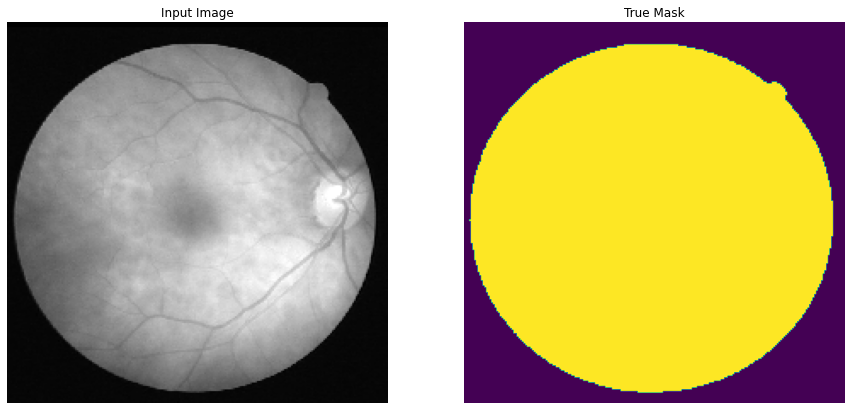

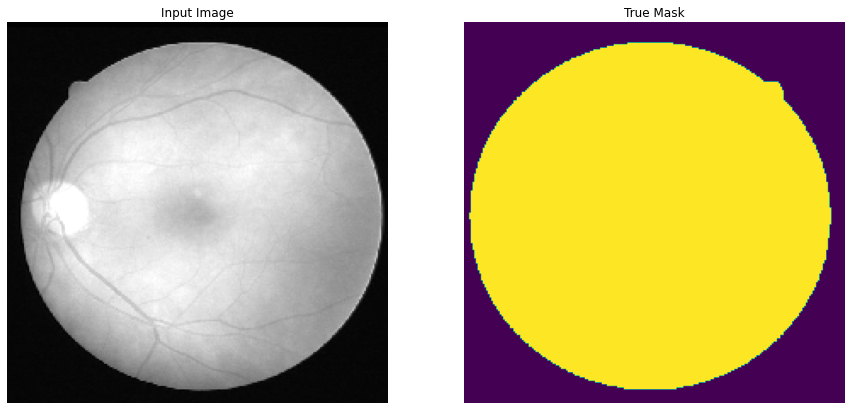

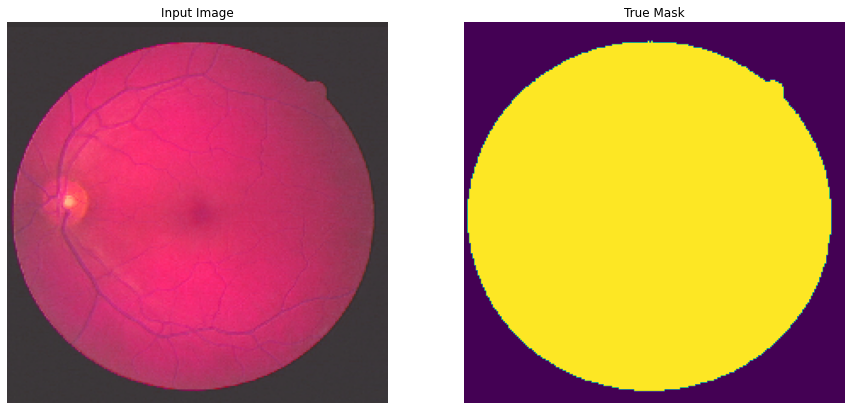

In [ ]:
for image, mask in train_dataset.take(3):
  # Extract a single image and mask from the batch
  image, mask = image[0], mask[0]
  # Display the image and mask
  display([image, mask])


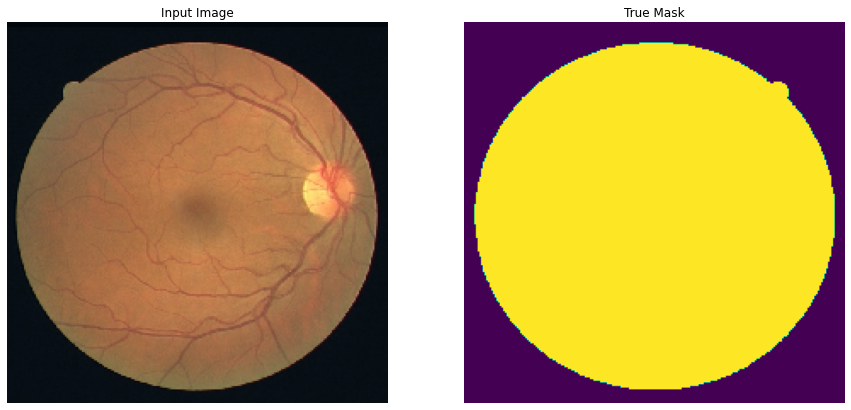

In [ ]:
for image, mask in validation_dataset.take(3):
  # Extract a single image and mask from the batch
  image, mask = image[0], mask[0]
  # Display the image and mask
  display([image, mask])

In [ ]:
EPOCHS = 350

# Enable eager execution globally
tf.config.run_functions_eagerly(True)

# Train the model
model_history = my_unet.fit(train_dataset, epochs=EPOCHS, validation_data= validation_dataset, verbose=1)
                                                                                                                                      

Epoch 1/350
5/5 [==============================] - 73s 14s/step - loss: 0.3540 - accuracy: 0.5532 - val_loss: 0.4196 - val_accuracy: 0.6344
Epoch 2/350
5/5 [==============================] - 73s 14s/step - loss: 0.3351 - accuracy: 0.5720 - val_loss: 0.4164 - val_accuracy: 0.6879
Epoch 3/350
5/5 [==============================] - 70s 14s/step - loss: 0.3216 - accuracy: 0.5882 - val_loss: 0.4127 - val_accuracy: 0.6875
Epoch 4/350
5/5 [==============================] - 74s 15s/step - loss: 0.3095 - accuracy: 0.6013 - val_loss: 0.4086 - val_accuracy: 0.6875
Epoch 5/350
5/5 [==============================] - 71s 14s/step - loss: 0.2977 - accuracy: 0.6111 - val_loss: 0.4041 - val_accuracy: 0.6875
Epoch 6/350
5/5 [==============================] - 70s 14s/step - loss: 0.2870 - accuracy: 0.6209 - val_loss: 0.3992 - val_accuracy: 0.6875
Epoch 7/350
5/5 [==============================] - 71s 14s/step - loss: 0.2772 - accuracy: 0.6299 - val_loss: 0.3934 - val_accuracy: 0.6876
Epoch 8/350
5/5 [===

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

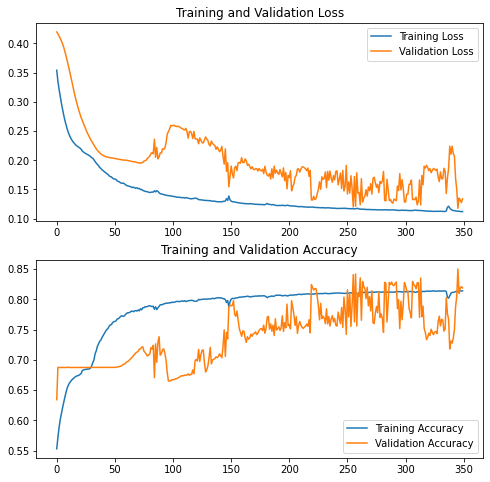

In [ ]:
# Plot the training and validation loss and accuracy
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

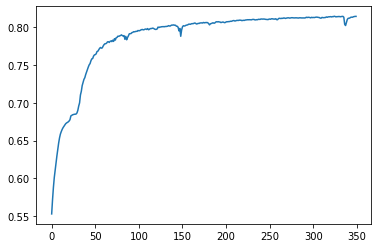

In [ ]:
plt.plot(model_history.history["accuracy"])

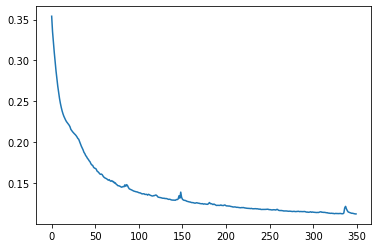

In [ ]:
plt.plot(model_history.history["loss"])

In [ ]:
evaluation_results = my_unet.evaluate(train_dataset)
print("test loss, test acc:", evaluation_results)

5/5 [==============================] - 15s 3s/step - loss: 0.1341 - accuracy: 0.8273
test loss, test acc: [0.13411560654640198, 0.8273463249206543]


In [ ]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = my_unet.predict(image)
            # pred_mask = tf.squeeze(pred_mask, axis=(2,))
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([image, mask,
             create_mask(my_unet.predict(image[tf.newaxis, ...]))])

In [ ]:
show_predictions(train_dataset, 5)

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.round(pred_mask)
#     pred_mask = tf.argmax(pred_mask, axis=-1)
#     pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = my_unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([image, mask,
             create_mask(my_unet.predict(image[tf.newaxis, ...]))])

In [ ]:
show_predictions(train_dataset, 10)